# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Detect environment

In [2]:
from pkg.marker_config import *
from pkg.environment_builder import *
from pkg.geometry import *
from pkg.utils import *

init_stereo()
aruco_map, dictionary = get_aruco_config()

ROBOTS_ON_SCENE = [("indy0", RobotType.indy7_robot), ("panda1", RobotType.panda_robot)]
JOINT_NAMES_DEFINED = ['indy0_joint0', 'indy0_joint1', 'indy0_joint2', 'indy0_joint3', 'indy0_joint4', 'indy0_joint5',
                   'panda1_joint1', 'panda1_joint2', 'panda1_joint3', 'panda1_joint4', 
                   'panda1_joint5', 'panda1_joint6', 'panda1_joint7']
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,np.pi/2])

Start streaming
Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [3]:
kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)

xyz_rpy_robots, xyz_rvec_cams, env_gen_dict, objectPose_dict, corner_dict, color_image  = \
    detect_environment(
        aruco_map, dictionary, robot_tuples=ROBOTS_ON_SCENE,
        env_dict={'floor': CallHolder(GeoBox, ["center", "orientation"], BLH=(3,3,0.01)), 
                  'wall':CallHolder(GeoBox, ["center", "orientation"], BLH=(3,3,0.01))},  
        camT_dict={"cam0":np.identity(4), "cam1": T_c12}, 
        ref_name='floor')

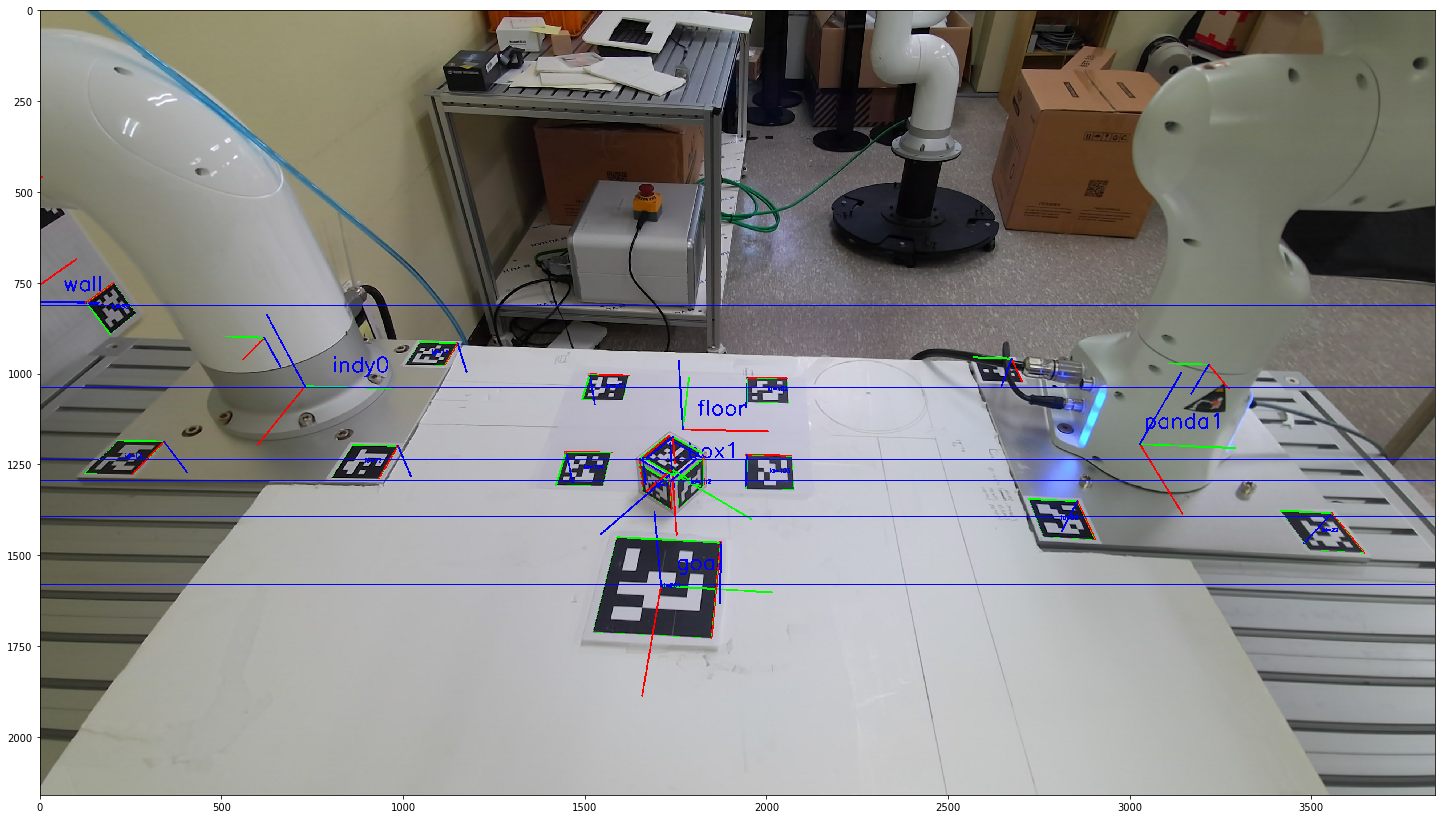

In [4]:
plt.figure(figsize=(25,15))
color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

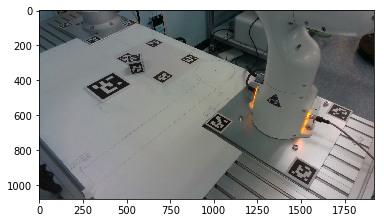

In [5]:
plt.imshow(get_rs_image())

In [6]:
# with open('config.pkl', 'wb') as f:
#     pickle.dump({"objectPose_dict":objectPose_dict, "corner_dict":corner_dict}, f)

In [7]:
# disconnRobotType.indy7_robotect_stereo()

# Define robot config

In [8]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer(ROBOTS_ON_SCENE, xyz_rpy_robots)

vel_scale, acc_scale = 0.5, 0.5
custom_limits = {}
XacroCustomizer.update_limit_dict(custom_limits, "vel", JOINT_NAMES_DEFINED, 
                                  vel_scale * np.deg2rad(
        [150, 150, 150, 180, 180, 180, 150, 150, 150, 150, 180, 180, 180]))
XacroCustomizer.update_limit_dict(custom_limits, "acc", JOINT_NAMES_DEFINED, 
                                  acc_scale * np.deg2rad(
        [360]*len(JOINT_NAMES_DEFINED)))

JOINT_NAMES, LINK_NAMES, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        joint_offset_dict={},
        joint_limit_dict=custom_limits)
refine_meshes()
xcustom.start_rviz()

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


# Create Graph

In [9]:
from pkg.constraint_graph import *
from pkg.constants import *
from pkg.plot_utils import *
from pkg.utils import *

rospy.init_node('task_planner', anonymous=True)

In [10]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = True, connect_indy = True)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

add_cam_poles(graph, xyz_rvec_cams)
add_objects_gen(graph, env_gen_dict)

Connect: Server IP (192.168.0.63)


## add custom meshes

In [11]:
graph.add_geometry_items("world", 
                         [
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi*2/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox(np.dot(Rot_axis(3,np.pi*2/16), (-0.055, 0,0.010)), (0.05,0.05,0.07), orientation=(0,0,np.pi*2/16), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.5), collision=True)
    ], fixed=True)

## Register binders

In [12]:
graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,11e-2], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=np.dot(Rot_axis(3,np.pi*2/16), (-0.055, 0,0.046)), link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

# Add objects

In [13]:
MOVABLE_GENERATORS = {'box1': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.8,0.3,0.3,1)), 
                 'box2': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.3,0.3,0.8,1)), 
                 'box3': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.8,0.8,0.8,1)), 
                 'goal': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.1, 0.1,0.005), color=(0.8,0.0,0.0,1))}
BINDER_DICT = {'goal_bd': dict(_type=PlaceFrame, object_name="goal", point=[0,0,0.0025], orientation=[0,0,0])}
OBJECT_DICT = {'box1': dict(_type=BoxAction, hexahedral=True),
               'box2': dict(_type=BoxAction, hexahedral=True),
               'box3': dict(_type=BoxAction, hexahedral=True)}

put_point_box1: right_p


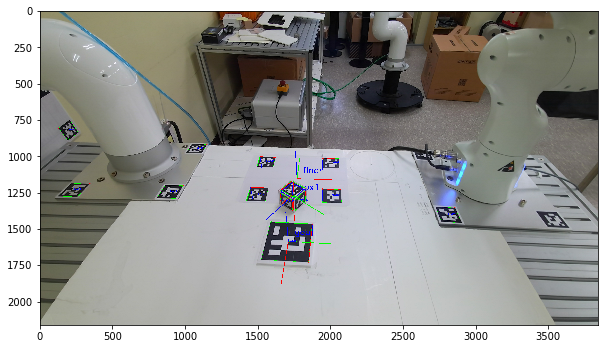

In [14]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
T_mv_dict, put_point_dict = register_objects(graph, objectPose_dict_mv, MOVABLE_GENERATORS, BINDER_DICT, OBJECT_DICT, 
                 ref_tuple=("floor", objectPose_dict["floor"]), link_name="world")

plt.figure(figsize=(10,8))
aruco_map_mv.update({'floor': aruco_map['floor']})
color_image_out = draw_objects(color_image, aruco_map_mv, objectPose_dict_mv, corner_dict_mv, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

# Set RVIZ

In [15]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


2048.2890605926514

In [16]:
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)

Connect: Server IP (192.168.0.63)


# Search Graph (Custom Robots)

In [17]:
graph.build_graph()

In [18]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
objectPose_dict_mv.update({'floor': objectPose_dict['floor']})

In [19]:
dt_sim = 0.02
T_step = 10
N_fullstep = int(T_step / dt_sim)
gtimer.reset()
initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                      {oname: get_T_rel('floor', oname, objectPose_dict_mv) for oname in graph.object_list}, 
                      (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                       else ZERO_JOINT_POSE))

goal_state = initial_state.copy()
goal_state.obj_pos_dict = None
goal_state.Q = None
goal_state.node = tuple([(oname,'right_f', 'goal_bd') if oname == "box1" else (oname, put_point_dict[oname],'floor') for oname in graph.object_list])

# goal_state = State((('box1','right_f','goal_bd'),), None, None)
graph.search_graph_mp(
    initial_state = initial_state, goal_state = goal_state,
    tree_margin = 4, depth_margin = 2, joint_motion_num=10, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=dt_sim, verbose = True, print_expression=False,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
print(gtimer)

Connect: Server IP (192.168.0.63)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.71 s, err: 0.00094932783484)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->2 (0.96 s, err: 0.000935971416892)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->3 (1.08 s, err: 0.000960125311376)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 1->4 (1.34 s, err: 0.000904010905237)
node: (('box1', 'left_p', 'vac2'),)->(('box1', 'right_f', 'goal_bd'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->5 (1.59 s, err: 0.000952259738505)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'back_p', 'grip1'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 3->6 (1.92 s, err: 0.00092678084097)
node: (('box1', 'front_p', 'grip1'),)->(('box1', 'r

In [20]:
len(graph.node_list)

24

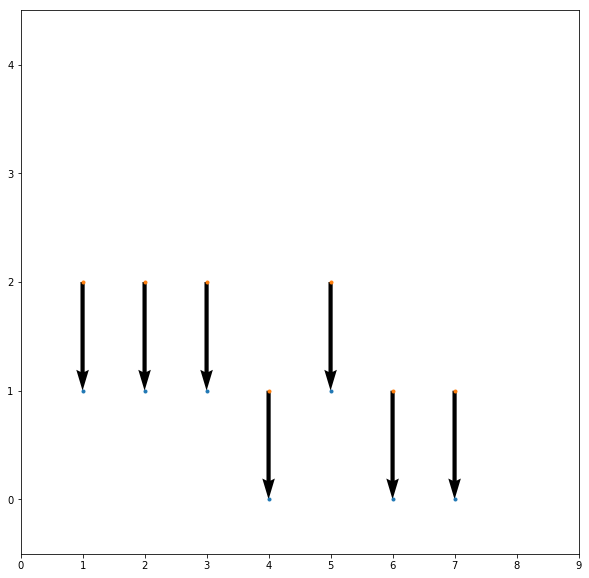

In [21]:
graph.quiver_snodes()

# Replay schedule

In [22]:
N_fullstep = 500
dt_vis = 0.02
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted, range(len(schedule_sorted))):
    e, end_state, success = graph.simulate_transition(
        graph.snode_dict[0].state, graph.snode_dict[0].state, 
        N=10, dt=dt_sim, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(0.1)
#     try:
    e = graph.replay(schedule, N=N_fullstep, dt=dt_vis, N_step=N_fullstep, 
                     vel_conv=1e-2, err_conv=5e-4, error_skip=0)
#     except Exception as e:
#         print(e)

[0, 1, 4]
[0, 3, 6]
[0, 2, 7]

--------------------
1-(('box1', 'left_p', 'vac2'),)

--------------------
4-(('box1', 'right_f', 'goal_bd'),)

--------------------
3-(('box1', 'front_p', 'grip1'),)

--------------------
6-(('box1', 'right_f', 'goal_bd'),)

--------------------
2-(('box1', 'bottom_p', 'grip1'),)

--------------------
7-(('box1', 'right_f', 'goal_bd'),)


# Execute traj online

In [32]:
schedule = schedule_sorted[0]
state_scedule = [graph.snode_dict[i_sc].state for i_sc in schedule]
state_scedule.append(state_scedule[-1].copy())
state_scedule[-1].Q = ZERO_JOINT_POSE

In [33]:
graph.execute_schedule_online(state_scedule)

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


# onestep

In [24]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
objectPose_dict_mv.update({'floor': objectPose_dict['floor']})

dt_sim = 0.02
T_step = 10
N_fullstep = int(T_step / dt_sim)
gtimer.reset()
initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                      {oname: get_T_rel('floor', oname, objectPose_dict_mv) for oname in graph.object_list}, 
                      (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                       else ZERO_JOINT_POSE))

goal_state = initial_state.copy()
goal_state.obj_pos_dict = None
goal_state.Q = None
goal_state.node = tuple([(oname,'right_f', 'goal_bd') if oname == "box1" else (oname, put_point_dict[oname],'floor') for oname in graph.object_list])


graph.search_graph_mp(
    initial_state = initial_state, goal_state = goal_state,
    tree_margin = 4, depth_margin = 2, joint_motion_num=10, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=dt_sim, verbose = True, print_expression=False,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)

schedule = schedule_sorted[0]
state_scedule = [graph.snode_dict[i_sc].state for i_sc in schedule]
state_scedule.append(state_scedule[-1].copy())
state_scedule[-1].Q = ZERO_JOINT_POSE

graph.execute_schedule_online(state_scedule)

Connect: Server IP (192.168.0.63)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.69 s, err: 0.000885574917767)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->2 (1.01 s, err: 0.000953902062005)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 1->3 (1.32 s, err: 0.000938707626932)
node: (('box1', 'left_p', 'vac2'),)->(('box1', 'right_f', 'goal_bd'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->4 (1.39 s, err: 0.000978004662643)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->5 (1.66 s, err: 0.000916509890958)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 2->6 (1.82 s, err: 0.000968208025182)
node: (('box1', 'front_p', 'grip1'),)->(('box1', 'ri

# test get traj

In [21]:
gtimer.reset()

In [22]:
schedule = schedule_sorted[0]
control_freq, playback_rate = DEFAULT_TRAJ_FREQUENCY, 0.5


state_scedule = [graph.snode_dict[i_sc].state for i_sc in schedule]
state_scedule.append(state_scedule[-1].copy())
state_scedule[-1].Q = ZERO_JOINT_POSE

e_POS_list = []
from_Q = state_scedule[0].Q
for i_s in range(len(state_scedule)-1):
    from_state = state_scedule[i_s]
    from_state.Q = from_Q
    to_state = state_scedule[i_s+1]
    kwargs = dict(vel_conv=0, err_conv=5e-4)

    self = graph
    from_state, to_state = from_state, to_state
    control_freq=control_freq
    T_step=10
    playback_rate=playback_rate

    dt = 1.0 / control_freq
    dt_sim = dt * playback_rate
    N = int(float(T_step) / dt_sim)
    e, new_state, succ = self.simulate_transition(from_state, to_state,
                                                  N=N, dt=dt_sim,
                                                  display=False, dt_vis=dt, N_step=N,
                                                  **kwargs)
    from_Q = e.POS[-1]
    print("{} sec / {} Hz / {} rate : {}".format(T_step , 1 / dt, playback_rate , N))
    e_POS_list.append(e.POS)


10 sec / 50.0 Hz / 0.5 rate : 1000
10 sec / 50.0 Hz / 0.5 rate : 1000
10 sec / 50.0 Hz / 0.5 rate : 1000


# Execute traj

In [26]:
for i_s in range(len(e_POS_list)):
    e_POS = e_POS_list[i_s]
#     graph.show_motion(e_POS, from_state=state_scedule[i_s], **{'error_skip':0, 'period':dt})

    gtimer.reset()
    Q0 = e_POS[0]
    graph.indy.joint_move_make_sure(np.rad2deg(Q0[graph.indy_idx]), N_repeat=2, connect=True)
    
    wait_di(graph.indy, 16)
    with MultiTracker([graph.indy, graph.panda],
                      [graph.indy_idx, graph.panda_idx],
                      Q0) as mt:
        time.sleep(0.5)

        qcount = 0
        qcount_indy_list = []
        qcount_panda_list = []
        looptime_list = []
        networktime_indy_list = []
        networktime_panda_list = []
        indy_sent = panda_sent = False
        i_q = 0
        while True:
            gtimer.tic("loop")
            Q = e_POS[i_q]

            all_sent = mt.move_possible_joints_x4(Q)

            if all_sent:
                i_q += 1
                if i_q >= len(e_POS):
                    break

            qcount_indy_list.append(graph.indy.qcount)
            qcount_panda_list.append(graph.panda.qcount)
            looptime_list.append(gtimer.toc("loop"))
    graph.execute_grip(state_scedule[i_s+1])

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


AttributeError: etasl_simulator instance has no attribute 'input_cb'

In [27]:

self.execute_grip(state_scedule[0])

Connect: Server IP (192.168.0.63)


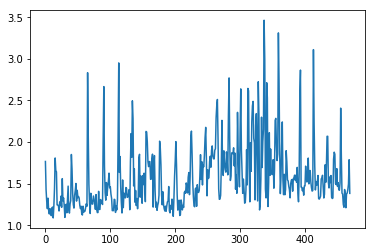

In [91]:
plt.plot(looptime_list)

In [71]:
pos_arr_list = []
POS_CUR = from_state.Q
VEL_CUR = np.zeros_like(POS_CUR)
end_loop = False
for i_sim in range(len(e_sim.TIME)):
    gtimer.tic("simulate_step")
    gtimer.tic("predict")
#     kf.predict()
    gtimer.toc("predict")
    try:
        pos = e_sim.simulate_step(i_sim, pos, dt=None, 
                                  inp_cur=None, inpvel_cur=None)        
        VEL_CUR = VEL_CUR+e_sim.VEL[i_sim,1::2] * e_sim.DT
        POS_CUR = POS_CUR + VEL_CUR * e_sim.DT
        gtimer.tic("update")
        #  kf.update(dict_to_array(pos, self.joint_names))
        gtimer.toc("update")
    except EventException:
        print(e)
        end_loop = True
    except Exception as e:
        error_count += 1
        print("ERROR {}: {}".format(error_count, e))
        if error_count > max_err_count:
            print("MAX ERROR REACHED {}".format(error_count))
            raise(e)
        # pos = array_to_dict(kf.x, self.pos_lbl)
        POS_CUR = dict_to_array(pos, self.joint_names)
    pos_arr_list.append(POS_CUR)
    gtimer.toc("simulate_step")
    if end_loop:
        break
from_Q = POS_CUR

exit


In [ ]:

error_count = 0
POS_CUR = from_state.Q
VEL_CUR = np.zeros_like(POS_CUR)
end_loop = False
for i_sim in range(len(e_sim.TIME)):
    gtimer.tic("simulate_step")
    gtimer.tic("predict")
#     kf.predict()
    gtimer.toc("predict")
    try:
        pos = e_sim.simulate_step(i_sim, pos, dt=None, 
                                  inp_cur=inp[i_sim], inpvel_cur=None)        
        VEL_CUR = VEL_CUR+e_sim.VEL[i_sim,1::2] * e_sim.DT
        POS_CUR = POS_CUR + VEL_CUR * e_sim.DT
        gtimer.tic("update")
#         kf.update(dict_to_array(pos, self.joint_names))
        gtimer.toc("update")
    except EventException:
        end_loop = True
    except Exception as e:
        error_count += 1
        print("ERROR {}: {}".format(error_count, e))
        if error_count > max_err_count:
            print("MAX ERROR REACHED {}".format(error_count))
            raise(e)
#         pos = array_to_dict(kf.x, self.pos_lbl)
        POS_CUR = dict_to_array(pos, self.joint_names)
    pos_arr = POS_CUR
    pos_panda = pos_arr[self.panda_idx]
    self.panda.rate.sleep()
    if move_robot:
        self.panda.send_qval(pos_panda)
    gtimer.toc("simulate_step")
    if end_loop:
        break
from_Q = pos_arr
from_Q[self.indy_idx] = e_POS[-1,self.indy_idx]
del traj_data_list

In [ ]:
schedule = schedule_sorted[0]
control_freq, playback_rate = DEFAULT_TRAJ_FREQUENCY, 0.5


state_scedule = [graph.snode_dict[i_sc].state for i_sc in schedule]
state_scedule.append(state_scedule[-1].copy())
state_scedule[-1].Q = ZERO_JOINT_POSE

e_POS_list = []
T_step=10
from_Q = state_scedule[0].Q
for i_s in range(len(state_scedule)-1):
    from_state = state_scedule[i_s]
    from_state.Q = from_Q
    to_state = state_scedule[i_s+1]
    kwargs = dict(vel_conv=0, err_conv=5e-4)

    self = graph
    from_state, to_state = from_state, to_state
    control_freq=control_freq
    playback_rate=playback_rate

    dt = 1.0 / control_freq
    dt_sim = dt * playback_rate
    N = int(float(T_step) / dt_sim)
    e, new_state, succ = self.simulate_transition(from_state, to_state,
                                                  N=N, dt=dt_sim,
                                                  display=False, dt_vis=dt, N_step=N,
                                                  **kwargs)
    from_Q = e.POS[-1]
    print("{} sec / {} Hz / {} rate : {}".format(T_step , 1 / dt, playback_rate , N))
    e_POS_list.append(e.POS)


In [26]:
for i_s in range(len(e_POS_list)):
    e_POS = e_POS_list[i_s]
#     graph.show_motion(e_POS, from_state=state_scedule[i_s], **{'error_skip':0, 'period':dt})

    gtimer.reset()
    Q0 = e_POS[0]
    graph.indy.joint_move_make_sure(np.rad2deg(Q0[graph.indy_idx]), N_repeat=2, connect=True)
    
    wait_di(graph.indy, 16)
    with MultiTracker([graph.indy, graph.panda],
                      [graph.indy_idx, graph.panda_idx],
                      Q0) as mt:
        time.sleep(0.1)

        qcount_indy_list = []
        qcount_panda_list = []
        looptime_list = []
        
        indy_sent = panda_sent = False
        i_q = 0
        max_loop = len(e)
        while True:
            gtimer.tic("loop")
            Q = e_POS[i_q]

            all_sent = True #mt.move_possible_joints_x4(Q)

            if all_sent:
                i_q += 1
                try:
                    pos = e_sim.simulate_step(i_q, pos, dt=None, 
                                              inp_cur=[], inpvel_cur=None)        
                    VEL_CUR = VEL_CUR+e_sim.VEL[i_q,1::2] * e_sim.DT
                    POS_CUR = POS_CUR + VEL_CUR * e_sim.DT
                    gtimer.tic("update")
            #         kf.update(dict_to_array(pos, self.joint_names))
                    gtimer.toc("update")
                except EventException:
                    end_loop = True
                except Exception as e:
                    error_count += 1
                    print("ERROR {}: {}".format(error_count, e))
                    if error_count > max_err_count:
                        print("MAX ERROR REACHED {}".format(error_count))
                        raise(e)
            #         pos = array_to_dict(kf.x, self.pos_lbl)
                    POS_CUR = dict_to_array(pos, self.joint_names)
                if i_q >= len(e_POS):
                    break
    if end_loop:
        break

            qcount_indy_list.append(graph.indy.qcount)
            qcount_panda_list.append(graph.panda.qcount)
            looptime_list.append(gtimer.toc("loop"))
    graph.execute_grip(state_scedule[i_s+1])

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


In [ ]:
i_s = 1
gtimer.tic("init_param")
from_state = self.snode_dict[schedule[i_s]].state
from_state.Q = from_Q if i_s>0 else self.snode_dict[schedule[0]].state.Q
to_state = self.snode_dict[schedule[i_s+1]].state
e_POS = e_POS_list[i_s]
# kf = createKF(graph.joint_num, dt=1.0/control_freq_panda, P=1000, R=5, Q=0.1, 
#               X0=augment_jvals_dot(from_Q))
gtimer.toc("init_param")

# downsample trajectory
gtimer.tic("downsample")
e_POS_fl = e_POS[::int(control_freq_indy/control_freq_panda), :]
e_POS_fl_indy = e_POS_fl[:, self.indy_idx]
e_POS_fl_panda = e_POS_fl[:, self.panda_idx]
gtimer.toc("downsample")

gtimer.tic("prepare_memory")
inp = e_POS_fl_indy
N_panda = len(inp)

gtimer.toc("prepare_memory")

gtimer.tic("init_etasl")
e_sim, pos = self.init_panda_sync_indy(from_state, to_state, N_panda, 
                                       control_freq_panda=control_freq_panda*playback_speed, K_sync_indy=100)
gtimer.toc("init_etasl")

gtimer.tic("get_traj_dat")
traj_delay = np.tile(e_POS[0:1,:len(self.indy_idx)], 
                     [int(control_freq_indy*indy_traj_delay),1])
traj_type, traj_freq, dat_size = 1, 4000, 6
traj_data_list = graph.get_traj_dat(
    np.concatenate([traj_delay, e_POS[:,self.indy_idx]],axis=0), dt=dt)
gtimer.toc("get_traj_dat")
if move_robot:
    gtimer.tic("move_ext_traj_txt")
    graph.indy.move_ext_traj_txt(traj_type=traj_type, 
                                 traj_freq=traj_freq, dat_size=dat_size, 
                                 traj_data=traj_data_list)
    gtimer.toc("move_ext_traj_txt")
    
error_count = 0
POS_CUR = from_state.Q
VEL_CUR = np.zeros_like(POS_CUR)
end_loop = False
for i_sim in range(len(e_sim.TIME)):
    gtimer.tic("simulate_step")
    gtimer.tic("predict")
#     kf.predict()
    gtimer.toc("predict")
    try:
        pos = e_sim.simulate_step(i_sim, pos, dt=None, 
                                  inp_cur=inp[i_sim], inpvel_cur=None)        
        VEL_CUR = VEL_CUR+e_sim.VEL[i_sim,1::2] * e_sim.DT
        POS_CUR = POS_CUR + VEL_CUR * e_sim.DT
        gtimer.tic("update")
#         kf.update(dict_to_array(pos, self.joint_names))
        gtimer.toc("update")
    except EventException:
        end_loop = True
    except Exception as e:
        error_count += 1
        print("ERROR {}: {}".format(error_count, e))
        if error_count > max_err_count:
            print("MAX ERROR REACHED {}".format(error_count))
            raise(e)
#         pos = array_to_dict(kf.x, self.pos_lbl)
        POS_CUR = dict_to_array(pos, self.joint_names)
    pos_arr = POS_CUR
    pos_panda = pos_arr[self.panda_idx]
    self.panda.rate.sleep()
    if move_robot:
        self.panda.send_qval(pos_panda)
    gtimer.toc("simulate_step")
    if end_loop:
        break
from_Q = pos_arr
from_Q[self.indy_idx] = e_POS[-1,self.indy_idx]
del traj_data_list

loop: 	5194.0 ms/1042 = 4.984 ms (2.339/7.19)
execute_grip: 	199.0 ms/1 = 199.474 ms (199.474/199.474)
indy_grasp: 	199.0 ms/1 = 199.351 ms (199.351/199.351)
simulate_transition: 	2545.0 ms/3 = 848.473 ms (539.159/1339.938)
start set transition: 	4.0 ms/3 = 1.332 ms (0.822/1.752)
get_transition_context: 	4.0 ms/3 = 1.327 ms (0.815/1.745)
set_object_state: 	3.0 ms/9 = 0.378 ms (0.187/0.933)
start get_tf_text: 	1.0 ms/3 = 0.373 ms (0.325/0.432)
start get_collision_text: 	0.0 ms/3 = 0.161 ms (0.107/0.26)
start make_constraints: 	0.0 ms/3 = 0.05 ms (0.002/0.099)
set_simulate fun: 	2539.0 ms/3 = 846.424 ms (536.422/1338.223)
post: 	2.0 ms/3 = 0.699 ms (0.275/0.969)
post rebind: 	1.0 ms/2 = 0.675 ms (0.634/0.716)
rebind: 	1.0 ms/2 = 0.669 ms (0.628/0.711)
get_object_state: 	0.0 ms/3 = 0.014 ms (0.012/0.018)
show_motion: 	64432.0 ms/3 = 21477.387 ms (10430.976/39050.063)



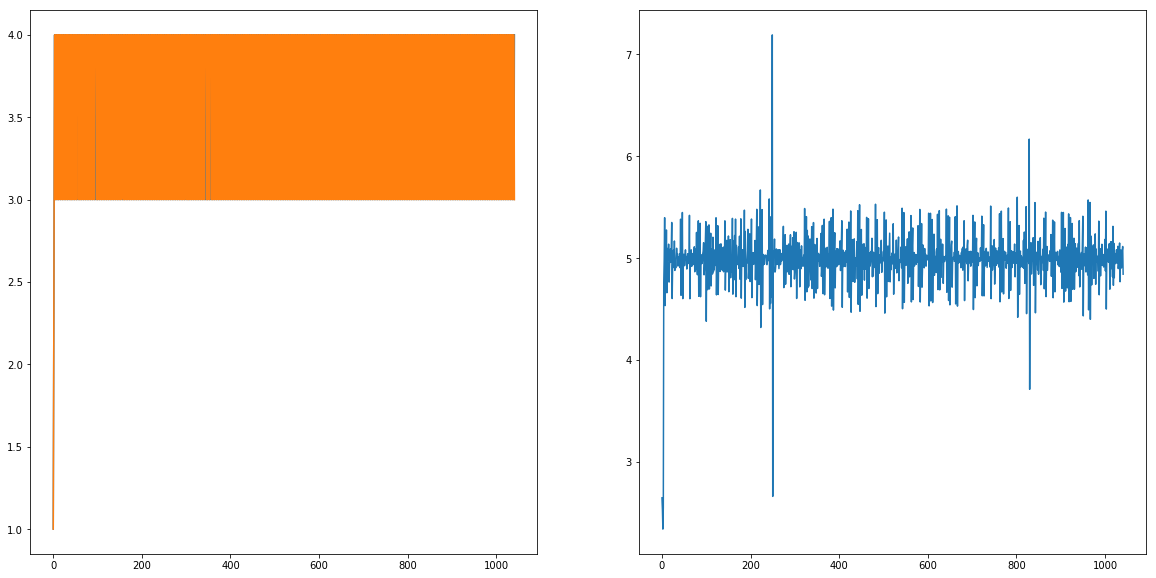

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
ax = plt.plot(qcount_indy_list)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,2,2)
ax = plt.plot(looptime_list)
print(gtimer)

# Going back

In [133]:
e_POS = e_POS_list[0]
self.panda.move_joint_interpolated(
    e_POS[0, graph.panda_idx], N_step=500, N_div=500)

In [35]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [101]:
newpppp = POS_list.copy()

In [102]:
newpppp[:,graph.panda_idx] = pos_panda_list

In [38]:
self.reset_panda()